<a href="https://colab.research.google.com/github/Henrislim/machine-learning-projects/blob/main/lending_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Loan Prediction

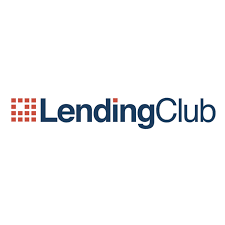

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. In this project, we use supervised learning models to identify whether the LC loan will be **default** in the future.
The results may be helpful to determine client's and make a prediction of their **loan interest rate**. [Dataset information](https://drive.google.com/file/d/1VOAhrB5eIhFc8C5qeFx5QYa2OLD7s1eV/view).

# Part 0: Setup Google Drive Environment

In [2]:
import pandas as pd
import numpy as np

import tabulate as tabulate

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# https://drive.google.com/file/d/1y5vNuOi25eYN9_nF52MEjufuw6ES1yj3/view?usp=sharing
file = drive.CreateFile({'id':'1y5vNuOi25eYN9_nF52MEjufuw6ES1yj3'}) # replace the id with id of file you want to access
file.GetContentFile('loan-clean-version.csv')

In [27]:
df = pd.read_csv('loan-clean-version.csv')

# Part 1: Data Exploration

Here is a full description of each fields. Please note that some fileds have been removed from the dataset.

LoanStatNew	 | Description
--- | ---
zip_code	|The first 3 numbers of the zip code provided by the borrower in the loan application.
addr_state	|The state provided by the borrower in the loan application
annual_inc|	The annual income provided by the borrower during registration.
collection_recovery_fee |	post charge off collection fee
collections_12_mths_ex_med |	Number of collections in 12 months excluding medical collections
delinq_2yrs	|The number of 30+ days past-due incidences of delinquency in the borrower’s credit file for the past 2 years
desc |	Loan description provided by the borrower
dti	| A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
earliest_cr_line	|The month the borrower’s earliest reported credit line was opened
emp_length|	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
emp_title|	The job title supplied by the Borrower when applying for the loan.
fico_range_high	|The upper boundary of range the borrower’s FICO belongs to.
fico_range_low|	The lower boundary of range the borrower’s FICO belongs to.
funded_amnt |	The total amount committed to that loan at that point in time.
funded_amnt_inv|	The total amount committed by investors for that loan at that point in time.
grade |	LC assigned loan grade
home_ownership|	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
id |	A unique LC assigned ID for the loan listing.
initial_list_status |	The initial listing status of the loan. Possible values are – W, F
inq_last_6mths |	The number of inquiries by creditors during the past 6 months.
installment	| The monthly payment owed by the borrower if the loan originates.
int_rate |	Interest Rate on the loan
is_inc_v |	Indicates if income was verified by LC, not verified, or if the income source was verified
issue_d	 | The month which the loan was funded
last_credit_pull_d |	The most recent month LC pulled credit for this loan
last_fico_range_high |	The last upper boundary of range the borrower’s FICO belongs to pulled.
last_fico_range_low |	The last lower boundary of range the borrower’s FICO belongs to pulled.
last_pymnt_amnt	| Last total payment amount received
last_pymnt_d |	Last month payment was received
loan_amnt |	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
loan_status |	Current status of the loan
member_id |	A unique LC assigned Id for the borrower member.
mths_since_last_delinq	| The number of months since the borrower’s last delinquency.
mths_since_last_major_derog	| Months since most recent 90-day or worse rating
mths_since_last_record |	The number of months since the last public record.
next_pymnt_d	| Next scheduled payment date
open_acc	| The number of open credit lines in the borrower’s credit file.
out_prncp |	Remaining outstanding principal for total amount funded
out_prncp_inv	| Remaining outstanding principal for portion of total amount funded by investors
policy_code |	Publicly available policy_code=1, new products not publicly available policy_code=2
pub_rec	|Number of derogatory public records
purpose	| A category provided by the borrower for the loan request.
pymnt_plan |	Indicates if a payment plan has been put in place for the loan
recoveries |	post charge off gross recovery
revol_bal |	Total credit revolving balance
revol_util|	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
sub_grade |	LC assigned loan subgrade
term	| The number of payments on the loan. Values are in months and can be either 36 or 60.
title |	The loan title provided by the borrower
total_acc	| The total number of credit lines currently in the borrower’s credit file
total_pymnt	|Payments received to date for total amount funded
total_pymnt_inv |	Payments received to date for portion of total amount funded by investors
total_rec_int	| Interest received to date
total_rec_late_fee|	Late fees received to date
total_rec_prncp	| Principal received to date
url	| URL for the LC page with listing data.

##1.1 Understand the Raw Dataset

In [ ]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,credit_card,AZ,27.65,31048,1,3,0,13648,83.7,9,0,0,5861.071414,5831.78,5000.00,861.07,Fully Paid
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,Less than 1 year,RENT,30000.0,Source Verified,car,GA,1.00,36251,5,3,0,1687,9.4,4,0,0,1008.710000,1008.71,456.46,435.17,Charged Off
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,small_business,IL,8.72,43040,2,2,0,2956,98.5,10,0,0,3003.653644,3003.65,2400.00,603.65,Fully Paid
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,other,CA,20.00,35096,1,10,0,5598,21.0,37,0,0,12226.302210,12226.30,10000.00,2209.33,Fully Paid
4,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,wedding,AZ,11.20,43043,3,9,0,7963,28.3,12,0,0,5631.377753,5631.38,5000.00,631.38,Fully Paid


In [ ]:
# check information of the data
# 9004 entries and 29 features/fileds
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9004 non-null   int64  
 1   loan_amnt            9004 non-null   int64  
 2   funded_amnt          9004 non-null   int64  
 3   funded_amnt_inv      9004 non-null   float64
 4   term                 9004 non-null   object 
 5   int_rate             9004 non-null   float64
 6   installment          9004 non-null   float64
 7   grade                9004 non-null   object 
 8   emp_length           8688 non-null   object 
 9   home_ownership       9004 non-null   object 
 10  annual_inc           9004 non-null   float64
 11  verification_status  9004 non-null   object 
 12  purpose              9004 non-null   object 
 13  addr_state           9004 non-null   object 
 14  dti                  9004 non-null   float64
 15  earliest_cr_line     9004 non-null   i

In [ ]:
# check unique values of each feature
df.nunique()

id                     9004
loan_amnt               604
funded_amnt             681
funded_amnt_inv        1234
term                      2
int_rate                 70
installment            3871
grade                     7
emp_length               11
home_ownership            3
annual_inc             1555
verification_status       3
purpose                  13
addr_state               45
dti                    2559
earliest_cr_line        458
inq_last_6mths            9
open_acc                 33
pub_rec                   3
revol_bal              7573
revol_util             1023
total_acc                63
out_prncp                 1
out_prncp_inv             1
total_pymnt            8962
total_pymnt_inv        8942
total_rec_prncp        2199
total_rec_int          8838
loan_status               2
dtype: int64

In [ ]:
# checking missing values
# null is found in two feastures, and they will be handled in Part 2
df.isnull().sum()

id                       0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
term                     0
int_rate                 0
installment              0
grade                    0
emp_length             316
home_ownership           0
annual_inc               0
verification_status      0
purpose                  0
addr_state               0
dti                      0
earliest_cr_line         0
inq_last_6mths           0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util               3
total_acc                0
out_prncp                0
out_prncp_inv            0
total_pymnt              0
total_pymnt_inv          0
total_rec_prncp          0
total_rec_int            0
loan_status              0
dtype: int64

In [ ]:
# check the target 'loan_status'
df.loc[:, 'loan_status'].value_counts()

Fully Paid     7487
Charged Off    1517
Name: loan_status, dtype: int64

## 1.2 Explorary Data Analysis (EDA)

In [ ]:
# correlation heatmap of numerial features
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

numericCol = []
for col in df:
  if df[col].dtype == np.float:
    numericCol.append(col)
corr = df[numericCol].corr()
corr

,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int
funded_amnt_inv,1.000000,0.302945,0.959195,0.371554,0.025192,0.022395,0.884368,0.885395,0.829373,0.734486
int_rate,0.302945,1.000000,0.267857,0.076103,0.091614,0.470893,0.259296,0.258493,0.124425,0.531955
installment,0.959195,0.267857,1.000000,0.385192,0.017451,0.056484,0.859719,0.859358,0.827792,0.660184
annual_inc,0.371554,0.076103,0.385192,1.000000,-0.176920,-0.005319,0.366455,0.364869,0.365577,0.253143
dti,0.025192,0.091614,0.017451,-0.176920,1.000000,0.243479,0.020130,0.019860,-0.004552,0.077365
revol_util,0.022395,0.470893,0.056484,-0.005319,0.243479,1.000000,0.022241,0.024014,-0.036570,0.171383
total_pymnt,0.884368,0.259296,0.859719,0.366455,0.020130,0.022241,1.000000,0.998224,0.968533,0.795019
total_pymnt_inv,0.885395,0.258493,0.859358,0.364869,0.019860,0.024014,0.998224,1.000000,0.966596,0.794365
total_rec_prncp,0.829373,0.124425,0.827792,0.365577,-0.004552,-0.036570,0.968533,0.966596,1.000000,0.634057
total_rec_int,0.734486,0.531955,0.660184,0.253143,0.077365,0.171383,0.795019,0.794365,0.634057,1.000000


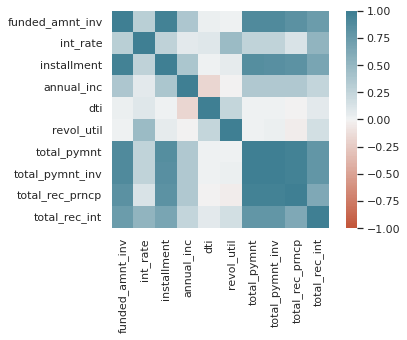

In [ ]:
ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap=sns.diverging_palette(20, 220, n=200), square = True)

**Observations:** Some features such as total_pymnt, total_pymnt_inv, and funded_amnt_inv have strong correlation.

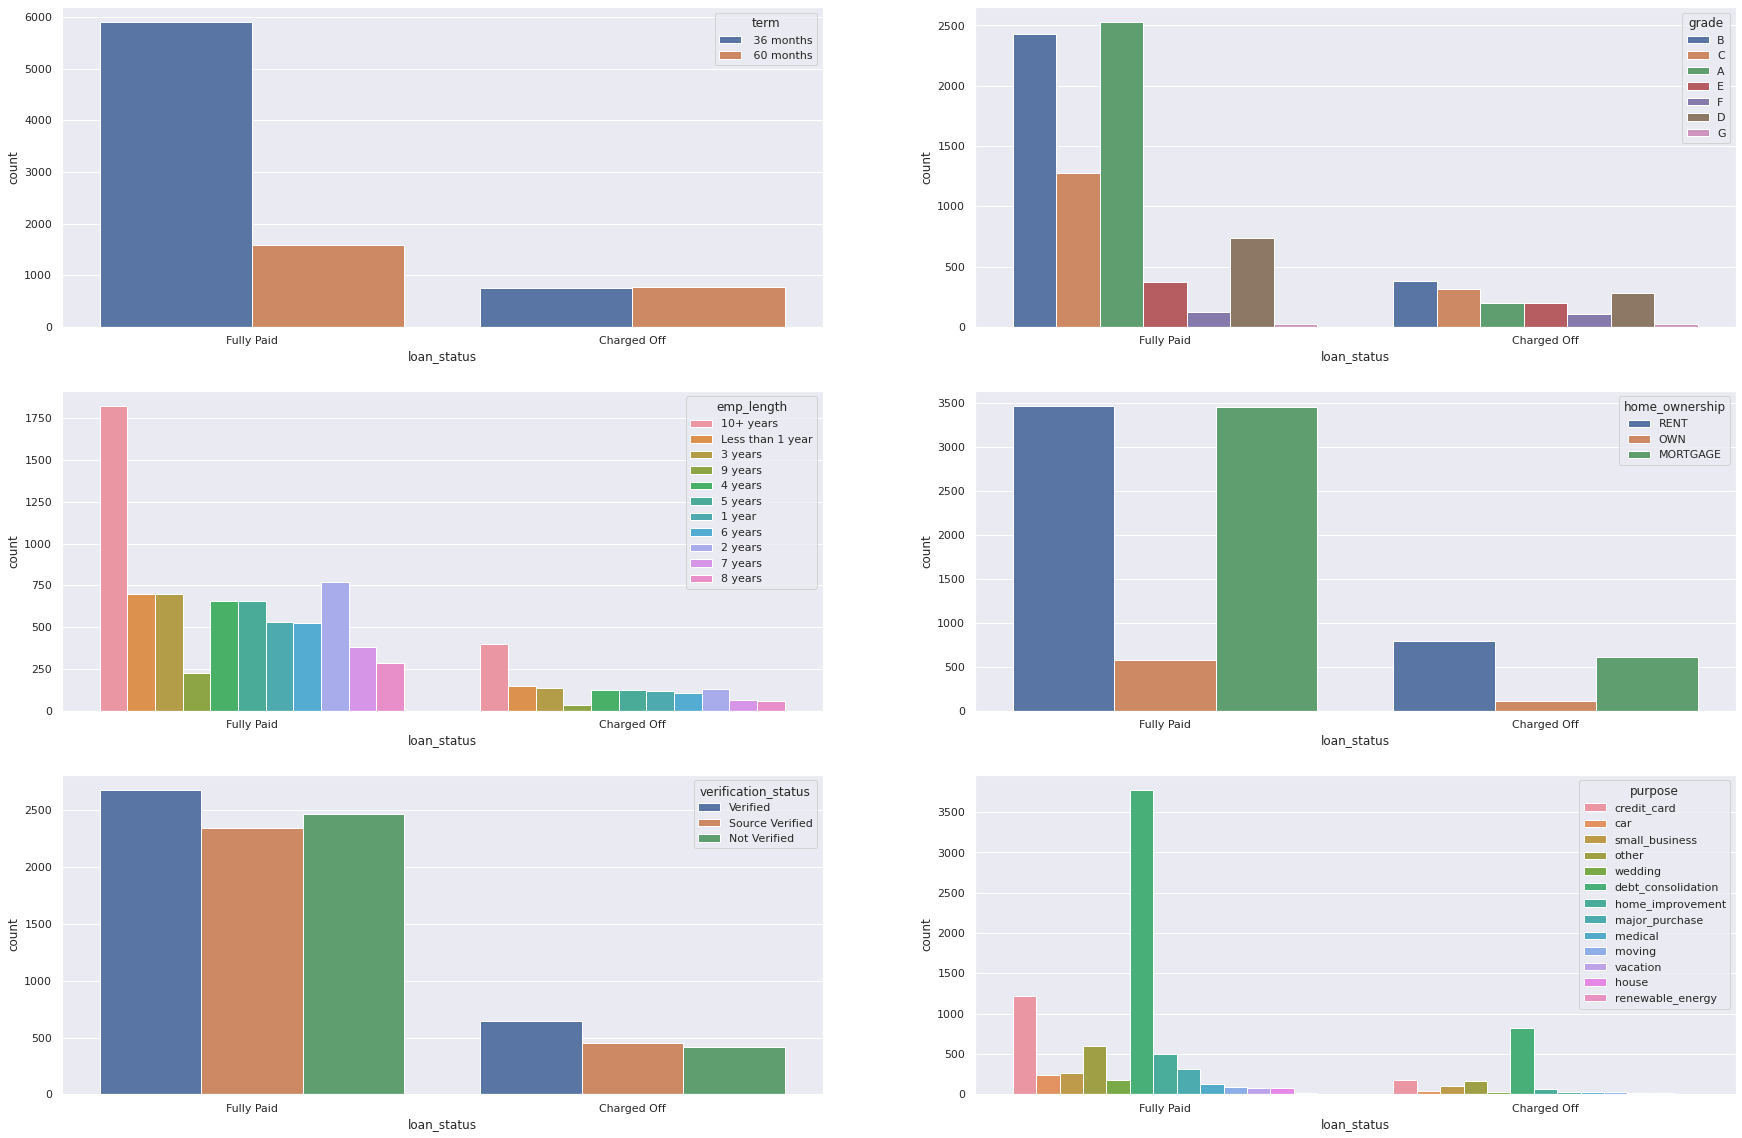

In [ ]:
# understand categorical feature
_,axss = plt.subplots(3,2, figsize=[30,20])
sns.countplot(x='loan_status', hue='term', data=df, ax=axss[0][0])
sns.countplot(x='loan_status', hue='grade', data=df, ax=axss[0][1])
sns.countplot(x='loan_status', hue='emp_length', data=df, ax=axss[1][0])
sns.countplot(x='loan_status', hue='home_ownership', data=df, ax=axss[1][1])
sns.countplot(x='loan_status', hue='verification_status', data=df, ax=axss[2][0])
sns.countplot(x='loan_status', hue='purpose', data=df, ax=axss[2][1])

# Part 2: Data cleaning and Feature Preprocessing

## 2.1 Data Cleaning

We convert "object" features into numerical features, drop nulls, and remove highly-corelated features.

In [83]:
df = pd.read_csv('loan-clean-version.csv')
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,credit_card,AZ,27.65,31048,1,3,0,13648,83.7,9,0,0,5861.071414,5831.78,5000.00,861.07,Fully Paid
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,Less than 1 year,RENT,30000.0,Source Verified,car,GA,1.00,36251,5,3,0,1687,9.4,4,0,0,1008.710000,1008.71,456.46,435.17,Charged Off
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,small_business,IL,8.72,43040,2,2,0,2956,98.5,10,0,0,3003.653644,3003.65,2400.00,603.65,Fully Paid
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,other,CA,20.00,35096,1,10,0,5598,21.0,37,0,0,12226.302210,12226.30,10000.00,2209.33,Fully Paid
4,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,wedding,AZ,11.20,43043,3,9,0,7963,28.3,12,0,0,5631.377753,5631.38,5000.00,631.38,Fully Paid


In [84]:
# numerical conversion
features = ('term', 'grade', 'home_ownership', 'verification_status', 'purpose',
           'addr_state')
for feature in features:
  class_mapping = {label: idx for idx, label in enumerate(np.unique(df[feature]))}
  df[feature] = df[feature].map(class_mapping)


class_mapping = {'Less than 1 year' : 0, '1 year' : 1, '2 years': 2, '3 years' : 3,
                '4 years': 4, '5 years' : 5, '6 years' : 6, '7 years' : 7,
                '8 years' : 8, '9 years' : 9, '10+ years' : 10}
df['emp_length'] = df['emp_length'].map(class_mapping)

class_mapping = {'Fully Paid' : 0, 'Charged Off' : 1}
df['loan_status']=df['loan_status'].map(class_mapping)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.0,0,10.65,162.87,1,10.0,2,24000.0,2,1,3,27.65,31048,1,3,0,13648,83.7,9,0,0,5861.071414,5831.78,5000.00,861.07,0
1,1077430,2500,2500,2500.0,1,15.27,59.83,2,0.0,2,30000.0,1,0,10,1.00,36251,5,3,0,1687,9.4,4,0,0,1008.710000,1008.71,456.46,435.17,1
2,1077175,2400,2400,2400.0,0,15.96,84.33,2,10.0,2,12252.0,0,10,12,8.72,43040,2,2,0,2956,98.5,10,0,0,3003.653644,3003.65,2400.00,603.65,0
3,1076863,10000,10000,10000.0,0,13.49,339.31,2,10.0,2,49200.0,1,8,4,20.00,35096,1,10,0,5598,21.0,37,0,0,12226.302210,12226.30,10000.00,2209.33,0
4,1075269,5000,5000,5000.0,0,7.90,156.46,0,3.0,2,36000.0,1,12,3,11.20,43043,3,9,0,7963,28.3,12,0,0,5631.377753,5631.38,5000.00,631.38,0


In [85]:
# deal with missing value
df = df.select_dtypes(include=[np.number]).dropna()
# drop high correlation colums
features = ["total_pymnt", "total_pymnt_inv","total_rec_int", "id", "total_rec_prncp"]
df = df.drop(features, axis=1)
df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,loan_status
0,5000,5000,4975.0,0,10.65,162.87,1,10.0,2,24000.0,2,1,3,27.65,31048,1,3,0,13648,83.7,9,0,0,0
1,2500,2500,2500.0,1,15.27,59.83,2,0.0,2,30000.0,1,0,10,1.00,36251,5,3,0,1687,9.4,4,0,0,1
2,2400,2400,2400.0,0,15.96,84.33,2,10.0,2,12252.0,0,10,12,8.72,43040,2,2,0,2956,98.5,10,0,0,0
3,10000,10000,10000.0,0,13.49,339.31,2,10.0,2,49200.0,1,8,4,20.00,35096,1,10,0,5598,21.0,37,0,0,0
4,5000,5000,5000.0,0,7.90,156.46,0,3.0,2,36000.0,1,12,3,11.20,43043,3,9,0,7963,28.3,12,0,0,0


## 2.2 Data Split

In [86]:
from sklearn.model_selection import train_test_split
y = df.loan_status
X = df.drop(['loan_status'], axis = 1)

# 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = .2)

## 2.3 Normalization

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Part 3: Model Training

## 3.1 Random Forest, KNeighbours, and Logistic Regression

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
classifier_logistic.fit(X_train, y_train)
prediction_Regression = classifier_logistic.predict(X_test)
print(classification_report(y_test,prediction_Regression))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1465
           1       0.48      0.05      0.10       273

    accuracy                           0.84      1738
   macro avg       0.67      0.52      0.51      1738
weighted avg       0.79      0.84      0.79      1738



In [92]:
classifier_KNN.fit(X_train, y_train)
prediction_KNN = classifier_KNN.predict(X_test)
print(classification_report(y_test,prediction_KNN))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1465
           1       0.38      0.13      0.19       273

    accuracy                           0.83      1738
   macro avg       0.62      0.54      0.55      1738
weighted avg       0.78      0.83      0.79      1738



In [93]:
classifier_RF.fit(X_train, y_train)
prediction_RF = classifier_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1465
           1       0.50      0.04      0.08       273

    accuracy                           0.84      1738
   macro avg       0.67      0.52      0.50      1738
weighted avg       0.79      0.84      0.78      1738



**Observation:**

0 represents the clients who can fully pay the lending.
Regarding the precision, it is around 0.85, which means that 85% out of those who are predicted to be fully-paid clients are real fully-paid clients.
Rgarding the recall, around 99% out of the really fully-paid clients are correctly predicted.

1 represents the default clients.
The precision of around 45% (on average) indicates that 45% of the predicted default clients are real default clients.
The recall of around 9% (on average) indicates that 9% of the real default clients are successfully predicted.


## 3.2 Cross Validation

In [94]:
# Use 5-fold Cross Validation to get the accuracy of different models
from sklearn import model_selection
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0
for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.8352518  0.8381295  0.83381295 0.83297336 0.8336933 ]
Model accuracy of Logistic Regression is 0.8347721822541967
[0.82158273 0.82517986 0.82302158 0.81065515 0.81713463]
Model accuracy of KNN is 0.819514789895945
[0.83165468 0.83165468 0.82661871 0.82937365 0.82361411]
Model accuracy of Random Forest is 0.8285831637066158


# Part 4: Feature Importance

We use random forest to rank the importance of different features.

In [99]:
forest = RandomForestClassifier()
forest.fit(X, y)
importance = forest.feature_importances_
indices = np.argsort(importance)[::-1]
# print feature importance ranking
print('Feature Importance from High to Low:')
for idx in range(X.shape[1]):
  print("{0} : {1}".format(X.columns[indices[idx]], round(importance[indices[idx]], 4)))

Feature Importance from High to Low:
annual_inc : 0.0766
revol_util : 0.0752
int_rate : 0.0734
dti : 0.0722
revol_bal : 0.0717
earliest_cr_line : 0.0705
installment : 0.061
total_acc : 0.0592
addr_state : 0.0518
funded_amnt_inv : 0.0518
open_acc : 0.046
funded_amnt : 0.0442
loan_amnt : 0.0434
emp_length : 0.038
term : 0.0346
grade : 0.0343
purpose : 0.0343
inq_last_6mths : 0.0242
verification_status : 0.0169
home_ownership : 0.0145
pub_rec : 0.0061
out_prncp : 0.0
out_prncp_inv : 0.0


# Part 5: Summary and Future Improvement

In this project, we play with client data from Lending Club to predict whether a client will default or not.
We first explicitly show how to explore and understand the dataset, and then clean the data for the model building in the next step.

Our different models have an accuracy of around 82%. Fully-paid clients are well predicted with a recall of around 99%.
However, only 9% (recall) of the default clients are successfully detected by the model. We believe that this can be further improved by selecting features and use other advanced model such as a neural network.  